# Module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import datetime as datetime
from math import isclose
from collections import Counter
import multiprocessing
import re
# Network libary
#import networkit as nk
import networkx as nx
from graph_tool.all import *
import stellargraph as sg
from stellargraph import StellarGraph, datasets
from stellargraph.datasets import IAEnronEmployees
from stellargraph.data import EdgeSplitter
from stellargraph import IndexedArray

# sklearn
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from stellargraph.mapper import FullBatchLinkGenerator, FullBatchNodeGenerator
from stellargraph.layer import GCN, LinkEmbedding
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification
from tensorflow import keras


2023-11-11 16:48:04.135666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-11 16:48:04.574553: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-11 16:48:05.712012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-11 16:48:05.712109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

# Functions

In [2]:



def create_biased_random_walker(graph, walk_num, walk_length):
    # parameter settings for "p" and "q":
    p = 1.0
    q = 1.0
    return BiasedRandomWalk(graph, n=walk_num, length=walk_length, p=p, q=q)

def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        iter=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

def gcn_embedding(graph, name):

    # Set the embedding dimensions and walk number:
    dimensions = [128, 128]
    walk_number = 1

    print(f"Training GCN for '{name}':")

    graph_node_list = list(graph.nodes())

    # Create the biased random walker to generate random walks
    walker = create_biased_random_walker(graph, walk_number, walk_length)

    # Create the unsupervised sampler to sample (target, context) pairs from random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=graph_node_list, walker=walker
    )

    # Define a GCN training generator, which generates the full batch of training pairs
    generator = FullBatchLinkGenerator(graph, method="gcn")

    # Create the GCN model
    gcn = GCN(
        layer_sizes=dimensions,
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.3,
    )

    # Build the model and expose input and output sockets of GCN, for node pair inputs
    x_inp, x_out = gcn.in_out_tensors()

    # Use the dot product of node embeddings to make node pairs co-occurring in short random walks represented closely
    prediction = LinkEmbedding(activation="sigmoid", method="ip")(x_out)
    prediction = keras.layers.Reshape((-1,))(prediction)

    # Stack the GCN encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],)

    # Train the model
    batches = unsupervised_samples.run(batch_size)
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")
        batch_iter = 1
        for batch in batches:
            samples = generator.flow(batch[0], targets=batch[1], use_ilocs=True)[0]
            [loss, accuracy] = model.train_on_batch(x=samples[0], y=samples[1])
            output = (
                f"{batch_iter}/{len(batches)} - loss:"
                + " {:6.4f}".format(loss)
                + " - binary_accuracy:"
                + " {:6.4f}".format(accuracy)
            )
            if batch_iter == len(batches):
                print(output)
            else:
                print(output, end="\r")
            batch_iter = batch_iter + 1

    # Get representations for all nodes in ``graph``
    embedding_model = keras.Model(inputs=x_inp, outputs=x_out)
    node_embeddings = embedding_model.predict(
        generator.flow(list(zip(graph_node_list, graph_node_list)))
    )
    node_embeddings = node_embeddings[0][:, 0, :]

    def get_embedding(u):
        u_index = graph_node_list.index(u)
        return node_embeddings[u_index]

    return get_embedding

# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]
# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf

def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0

%matplotlib inline

# Settings

In [3]:
walk_length = 5
batch_size = 100

# Load Data

In [4]:
loaded = np.load("/home/rh/Arbeitsraum/bitbucket/share/SLMI2/data/2022_6_2_law_500.npz",allow_pickle=True)


# Load train and test

In [5]:

#loaded = np.load("/home/rh/law_keiji_dyn_savez.npz",allow_pickle=True)
print(loaded.files)
edges_train = loaded["arr_0"]
labels_train = loaded["arr_1"]
edges_valid = loaded["arr_2"]
labels_valid = loaded["arr_3"]
edges_test = loaded["arr_4"]
labels_test = loaded["arr_5"]
features = loaded["arr_6"]
df_node2cnt = pd.DataFrame(loaded["arr_7"])

df_node2cnt.columns = ["index","node","cnt"]

node2index = dict()
for i in range(len(df_node2cnt)):
    node2index.update({df_node2cnt["node"].iloc[i]: df_node2cnt["index"].iloc[i]})
    

df_train_0 = pd.DataFrame(edges_train)
df_train_0[2] = labels_train
cond = df_train_0[2] == 1
df_train_1 = df_train_0.loc[cond].copy()
df_train = df_train_1[[0,1]].copy()
df_train.columns = ["source","target"]


df_train_0.columns = ["source","target","label"]

#df_train["source"] = df_train["source"].map(node2index)
#df_train["target"] = df_train["target"].map(node2index)
#df_train_0["source"] = df_train_0["source"].map(node2index)
#df_train_0["target"] = df_train_0["target"].map(node2index)

df_valid_0 = pd.DataFrame(edges_valid)
df_valid_0[2] = labels_valid
cond = df_valid_0[2] == 1
df_valid_1 = df_valid_0.loc[cond].copy()
df_valid = df_valid_1[[0,1]].copy()
df_valid.columns = ["source","target"]
df_valid_0.columns = ["source","target","label"]


#df_valid["source"] = df_valid["source"].map(node2index)
#df_valid["target"] = df_valid["target"].map(node2index)
#df_valid_0["source"] = df_valid_0["source"].map(node2index)
#df_valid_0["target"] = df_valid_0["target"].map(node2index)

df_test_0 = pd.DataFrame(edges_test)
df_test_0[2] = labels_test
cond = df_test_0[2] == 1
df_test_1 = df_test_0.loc[cond].copy()
df_test = df_test_1[[0,1]].copy()
df_test.columns = ["source","target"]
df_test_0.columns = ["source","target","label"]


#df_test["source"] = df_test["source"].map(node2index)
#df_test["target"] = df_test["target"].map(node2index)
#df_test_0["source"] = df_test_0["source"].map(node2index)
#df_test_0["target"] = df_test_0["target"].map(node2index)


df_node2cnt["node"] = df_node2cnt["node"].astype(str)
indexed_array = IndexedArray(features, index=list(df_node2cnt["node"]))
#indexed_array = IndexedArray( index=list(df_node2cnt["node"]))
tmp_nodes = list(set(df_train["source"]))
tmp_nodes.extend(list(set(df_train["target"])))
tmp_nodes = list(set(tmp_nodes))

['arr_0', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5', 'arr_6', 'arr_7']


# Create Stellar Objects

In [6]:
df_train["source"] = df_train["source"].astype(str)
df_train["target"] = df_train["target"].astype(str)

df_test["source"] = df_test["source"].astype(str)
df_test["target"] = df_test["target"].astype(str)

graph_train = StellarGraph(nodes=indexed_array,edges=df_train)
graph_test = StellarGraph(nodes=indexed_array,edges=df_test)
#print(graph_train.info())
#graph_test = StellarGraph(nodes=df_nodes,edges=df_test)
#print(graph_test.info())
# weight_
#
#graph_test = StellarGraph(edges=df_test)
#graph = StellarGraph(edges=df_edges_2[["source","target","weight"]])
#edge_splitter_test = EdgeSplitter(graph)
#graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
#    p=0.1, method="global")
#print(graph_test.info())
#df_test = pd.DataFrame(graph_test.edges())
#len(df_test)
#X = graph_test.to_adjacency_matrix()
#edge_splitter_train = EdgeSplitter(graph_test, graph)
#graph_train, examples, labels = edge_splitter_train.train_test_split(
#    p=0.1, method="global")
#(examples_train,examples_model_selection,labels_train,
#    labels_model_selection,) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)
#print(graph_train.info())
#df_train = pd.DataFrame(graph_train.edges())

In [7]:
print(graph_train.info())

StellarGraph: Undirected multigraph
 Nodes: 3521, Edges: 51430

 Node types:
  default: [3521]
    Features: float64 vector, length 5677
    Edge types: default-default->default

 Edge types:
    default-default->default: [51430]
        Weights: all 1 (default)
        Features: none


In [8]:
print(graph_test.info())

StellarGraph: Undirected multigraph
 Nodes: 3521, Edges: 17378

 Node types:
  default: [3521]
    Features: float64 vector, length 5677
    Edge types: default-default->default

 Edge types:
    default-default->default: [17378]
        Weights: all 1 (default)
        Features: none


# Run

In [9]:
train_gen = FullBatchLinkGenerator(graph_train, method="gcn")
train_flow = train_gen.flow(edges_train, labels_train)
test_gen = FullBatchLinkGenerator(graph_test, method="gcn")
test_flow = train_gen.flow(edges_test, labels_test)

gcn = GCN(
    layer_sizes=[250], activations=["relu"], 
    generator=train_gen, dropout=0.2
)

x_inp, x_out = gcn.in_out_tensors()
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)
prediction = keras.layers.Reshape((-1,))(prediction)
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss=keras.losses.binary_crossentropy,
    metrics=['acc']
)

#model.compile(loss='categorical_crossentropy', optimizer='adadelta',metrics=['acc'])
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 229ms/step - loss: 1.6077 - acc: 0.0000e+00

Train Set Metrics of the initial (untrained) model:
	loss: 1.5957
	acc: 0.0000

Test Set Metrics of the initial (untrained) model:
	loss: 1.6077
	acc: 0.0000


# Run

In [10]:
%%time
epochs = 1000
history = model.fit(
    train_flow, epochs=epochs, 
     validation_data=test_flow, verbose=2, shuffle=False)

Epoch 1/1000
1/1 - 2s - loss: 1.5929 - acc: 0.0000e+00 - val_loss: 0.6373 - val_acc: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 2/1000
1/1 - 0s - loss: 0.6344 - acc: 0.0000e+00 - val_loss: 0.4794 - val_acc: 0.0000e+00 - 474ms/epoch - 474ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.4769 - acc: 0.0000e+00 - val_loss: 0.4287 - val_acc: 0.0000e+00 - 451ms/epoch - 451ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.4262 - acc: 0.0000e+00 - val_loss: 0.4294 - val_acc: 0.0000e+00 - 476ms/epoch - 476ms/step
Epoch 5/1000
1/1 - 1s - loss: 0.4269 - acc: 0.0000e+00 - val_loss: 0.4577 - val_acc: 0.0000e+00 - 639ms/epoch - 639ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.4554 - acc: 0.0000e+00 - val_loss: 0.4949 - val_acc: 0.0000e+00 - 440ms/epoch - 440ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.4928 - acc: 0.0000e+00 - val_loss: 0.5260 - val_acc: 0.0000e+00 - 437ms/epoch - 437ms/step
Epoch 8/1000
1/1 - 0s - loss: 0.5246 - acc: 0.0000e+00 - val_loss: 0.5432 - val_acc: 0.0000e+00 - 455ms/epoch - 455ms/step
Epoch 9/1000
1/1 - 0s 

Epoch 68/1000
1/1 - 0s - loss: 0.4119 - acc: 0.0000e+00 - val_loss: 0.4139 - val_acc: 0.0000e+00 - 445ms/epoch - 445ms/step
Epoch 69/1000
1/1 - 0s - loss: 0.4117 - acc: 0.0000e+00 - val_loss: 0.4137 - val_acc: 0.0000e+00 - 470ms/epoch - 470ms/step
Epoch 70/1000
1/1 - 0s - loss: 0.4115 - acc: 0.0000e+00 - val_loss: 0.4135 - val_acc: 0.0000e+00 - 473ms/epoch - 473ms/step
Epoch 71/1000
1/1 - 0s - loss: 0.4113 - acc: 0.0000e+00 - val_loss: 0.4133 - val_acc: 0.0000e+00 - 452ms/epoch - 452ms/step
Epoch 72/1000
1/1 - 0s - loss: 0.4111 - acc: 0.0000e+00 - val_loss: 0.4131 - val_acc: 0.0000e+00 - 445ms/epoch - 445ms/step
Epoch 73/1000
1/1 - 0s - loss: 0.4110 - acc: 0.0000e+00 - val_loss: 0.4129 - val_acc: 0.0000e+00 - 458ms/epoch - 458ms/step
Epoch 74/1000
1/1 - 0s - loss: 0.4107 - acc: 0.0000e+00 - val_loss: 0.4127 - val_acc: 0.0000e+00 - 451ms/epoch - 451ms/step
Epoch 75/1000
1/1 - 0s - loss: 0.4105 - acc: 0.0000e+00 - val_loss: 0.4125 - val_acc: 0.0000e+00 - 465ms/epoch - 465ms/step
Epoch 76

Epoch 134/1000
1/1 - 1s - loss: 0.3978 - acc: 0.0000e+00 - val_loss: 0.3989 - val_acc: 0.0000e+00 - 505ms/epoch - 505ms/step
Epoch 135/1000
1/1 - 0s - loss: 0.3973 - acc: 0.0000e+00 - val_loss: 0.3987 - val_acc: 0.0000e+00 - 496ms/epoch - 496ms/step
Epoch 136/1000
1/1 - 1s - loss: 0.3972 - acc: 0.0000e+00 - val_loss: 0.3984 - val_acc: 0.0000e+00 - 511ms/epoch - 511ms/step
Epoch 137/1000
1/1 - 0s - loss: 0.3970 - acc: 0.0000e+00 - val_loss: 0.3981 - val_acc: 0.0000e+00 - 484ms/epoch - 484ms/step
Epoch 138/1000
1/1 - 0s - loss: 0.3967 - acc: 0.0000e+00 - val_loss: 0.3979 - val_acc: 0.0000e+00 - 489ms/epoch - 489ms/step
Epoch 139/1000
1/1 - 0s - loss: 0.3965 - acc: 0.0000e+00 - val_loss: 0.3976 - val_acc: 0.0000e+00 - 474ms/epoch - 474ms/step
Epoch 140/1000
1/1 - 0s - loss: 0.3962 - acc: 0.0000e+00 - val_loss: 0.3974 - val_acc: 0.0000e+00 - 463ms/epoch - 463ms/step
Epoch 141/1000
1/1 - 0s - loss: 0.3960 - acc: 0.0000e+00 - val_loss: 0.3971 - val_acc: 0.0000e+00 - 493ms/epoch - 493ms/step


Epoch 200/1000
1/1 - 0s - loss: 0.3818 - acc: 0.0000e+00 - val_loss: 0.3822 - val_acc: 0.0000e+00 - 468ms/epoch - 468ms/step
Epoch 201/1000
1/1 - 1s - loss: 0.3816 - acc: 0.0000e+00 - val_loss: 0.3819 - val_acc: 0.0000e+00 - 506ms/epoch - 506ms/step
Epoch 202/1000
1/1 - 0s - loss: 0.3813 - acc: 0.0000e+00 - val_loss: 0.3817 - val_acc: 0.0000e+00 - 469ms/epoch - 469ms/step
Epoch 203/1000
1/1 - 0s - loss: 0.3811 - acc: 0.0000e+00 - val_loss: 0.3815 - val_acc: 0.0000e+00 - 468ms/epoch - 468ms/step
Epoch 204/1000
1/1 - 0s - loss: 0.3807 - acc: 0.0000e+00 - val_loss: 0.3814 - val_acc: 0.0000e+00 - 462ms/epoch - 462ms/step
Epoch 205/1000
1/1 - 0s - loss: 0.3806 - acc: 0.0000e+00 - val_loss: 0.3812 - val_acc: 0.0000e+00 - 469ms/epoch - 469ms/step
Epoch 206/1000
1/1 - 0s - loss: 0.3804 - acc: 0.0000e+00 - val_loss: 0.3809 - val_acc: 0.0000e+00 - 488ms/epoch - 488ms/step
Epoch 207/1000
1/1 - 0s - loss: 0.3804 - acc: 0.0000e+00 - val_loss: 0.3807 - val_acc: 0.0000e+00 - 455ms/epoch - 455ms/step


Epoch 266/1000
1/1 - 0s - loss: 0.3655 - acc: 0.0000e+00 - val_loss: 0.3660 - val_acc: 0.0000e+00 - 456ms/epoch - 456ms/step
Epoch 267/1000
1/1 - 0s - loss: 0.3648 - acc: 0.0000e+00 - val_loss: 0.3657 - val_acc: 0.0000e+00 - 474ms/epoch - 474ms/step
Epoch 268/1000
1/1 - 0s - loss: 0.3648 - acc: 0.0000e+00 - val_loss: 0.3654 - val_acc: 0.0000e+00 - 471ms/epoch - 471ms/step
Epoch 269/1000
1/1 - 0s - loss: 0.3643 - acc: 0.0000e+00 - val_loss: 0.3650 - val_acc: 0.0000e+00 - 481ms/epoch - 481ms/step
Epoch 270/1000
1/1 - 0s - loss: 0.3638 - acc: 0.0000e+00 - val_loss: 0.3646 - val_acc: 0.0000e+00 - 473ms/epoch - 473ms/step
Epoch 271/1000
1/1 - 0s - loss: 0.3635 - acc: 0.0000e+00 - val_loss: 0.3643 - val_acc: 0.0000e+00 - 442ms/epoch - 442ms/step
Epoch 272/1000
1/1 - 0s - loss: 0.3631 - acc: 0.0000e+00 - val_loss: 0.3639 - val_acc: 0.0000e+00 - 468ms/epoch - 468ms/step
Epoch 273/1000
1/1 - 1s - loss: 0.3628 - acc: 0.0000e+00 - val_loss: 0.3636 - val_acc: 0.0000e+00 - 501ms/epoch - 501ms/step


Epoch 332/1000
1/1 - 0s - loss: 0.3362 - acc: 0.0000e+00 - val_loss: 0.3387 - val_acc: 0.0000e+00 - 480ms/epoch - 480ms/step
Epoch 333/1000
1/1 - 0s - loss: 0.3359 - acc: 0.0000e+00 - val_loss: 0.3385 - val_acc: 0.0000e+00 - 481ms/epoch - 481ms/step
Epoch 334/1000
1/1 - 0s - loss: 0.3352 - acc: 0.0000e+00 - val_loss: 0.3381 - val_acc: 0.0000e+00 - 479ms/epoch - 479ms/step
Epoch 335/1000
1/1 - 0s - loss: 0.3349 - acc: 0.0000e+00 - val_loss: 0.3378 - val_acc: 0.0000e+00 - 471ms/epoch - 471ms/step
Epoch 336/1000
1/1 - 0s - loss: 0.3345 - acc: 0.0000e+00 - val_loss: 0.3374 - val_acc: 0.0000e+00 - 462ms/epoch - 462ms/step
Epoch 337/1000
1/1 - 0s - loss: 0.3341 - acc: 0.0000e+00 - val_loss: 0.3370 - val_acc: 0.0000e+00 - 458ms/epoch - 458ms/step
Epoch 338/1000
1/1 - 0s - loss: 0.3337 - acc: 0.0000e+00 - val_loss: 0.3366 - val_acc: 0.0000e+00 - 449ms/epoch - 449ms/step
Epoch 339/1000
1/1 - 0s - loss: 0.3332 - acc: 0.0000e+00 - val_loss: 0.3363 - val_acc: 0.0000e+00 - 449ms/epoch - 449ms/step


Epoch 398/1000
1/1 - 0s - loss: 0.3174 - acc: 0.0000e+00 - val_loss: 0.3222 - val_acc: 0.0000e+00 - 458ms/epoch - 458ms/step
Epoch 399/1000
1/1 - 0s - loss: 0.3174 - acc: 0.0000e+00 - val_loss: 0.3221 - val_acc: 0.0000e+00 - 474ms/epoch - 474ms/step
Epoch 400/1000
1/1 - 0s - loss: 0.3170 - acc: 0.0000e+00 - val_loss: 0.3219 - val_acc: 0.0000e+00 - 463ms/epoch - 463ms/step
Epoch 401/1000
1/1 - 0s - loss: 0.3168 - acc: 0.0000e+00 - val_loss: 0.3217 - val_acc: 0.0000e+00 - 464ms/epoch - 464ms/step
Epoch 402/1000
1/1 - 0s - loss: 0.3166 - acc: 0.0000e+00 - val_loss: 0.3216 - val_acc: 0.0000e+00 - 477ms/epoch - 477ms/step
Epoch 403/1000
1/1 - 0s - loss: 0.3166 - acc: 0.0000e+00 - val_loss: 0.3214 - val_acc: 0.0000e+00 - 449ms/epoch - 449ms/step
Epoch 404/1000
1/1 - 0s - loss: 0.3161 - acc: 0.0000e+00 - val_loss: 0.3212 - val_acc: 0.0000e+00 - 474ms/epoch - 474ms/step
Epoch 405/1000
1/1 - 0s - loss: 0.3162 - acc: 0.0000e+00 - val_loss: 0.3210 - val_acc: 0.0000e+00 - 470ms/epoch - 470ms/step


Epoch 464/1000
1/1 - 0s - loss: 0.3249 - acc: 0.0000e+00 - val_loss: 0.3270 - val_acc: 0.0000e+00 - 452ms/epoch - 452ms/step
Epoch 465/1000
1/1 - 0s - loss: 0.3242 - acc: 0.0000e+00 - val_loss: 0.3263 - val_acc: 0.0000e+00 - 449ms/epoch - 449ms/step
Epoch 466/1000
1/1 - 0s - loss: 0.3238 - acc: 0.0000e+00 - val_loss: 0.3259 - val_acc: 0.0000e+00 - 471ms/epoch - 471ms/step
Epoch 467/1000
1/1 - 1s - loss: 0.3228 - acc: 0.0000e+00 - val_loss: 0.3253 - val_acc: 0.0000e+00 - 505ms/epoch - 505ms/step
Epoch 468/1000
1/1 - 0s - loss: 0.3223 - acc: 0.0000e+00 - val_loss: 0.3250 - val_acc: 0.0000e+00 - 451ms/epoch - 451ms/step
Epoch 469/1000
1/1 - 0s - loss: 0.3216 - acc: 0.0000e+00 - val_loss: 0.3244 - val_acc: 0.0000e+00 - 446ms/epoch - 446ms/step
Epoch 470/1000
1/1 - 0s - loss: 0.3215 - acc: 0.0000e+00 - val_loss: 0.3239 - val_acc: 0.0000e+00 - 445ms/epoch - 445ms/step
Epoch 471/1000
1/1 - 0s - loss: 0.3207 - acc: 0.0000e+00 - val_loss: 0.3232 - val_acc: 0.0000e+00 - 457ms/epoch - 457ms/step


Epoch 530/1000
1/1 - 0s - loss: 0.3043 - acc: 0.0000e+00 - val_loss: 0.3100 - val_acc: 0.0000e+00 - 471ms/epoch - 471ms/step
Epoch 531/1000
1/1 - 0s - loss: 0.3044 - acc: 0.0000e+00 - val_loss: 0.3098 - val_acc: 0.0000e+00 - 462ms/epoch - 462ms/step
Epoch 532/1000
1/1 - 0s - loss: 0.3043 - acc: 0.0000e+00 - val_loss: 0.3097 - val_acc: 0.0000e+00 - 462ms/epoch - 462ms/step
Epoch 533/1000
1/1 - 0s - loss: 0.3044 - acc: 0.0000e+00 - val_loss: 0.3095 - val_acc: 0.0000e+00 - 455ms/epoch - 455ms/step
Epoch 534/1000
1/1 - 0s - loss: 0.3045 - acc: 0.0000e+00 - val_loss: 0.3094 - val_acc: 0.0000e+00 - 456ms/epoch - 456ms/step
Epoch 535/1000
1/1 - 0s - loss: 0.3037 - acc: 0.0000e+00 - val_loss: 0.3092 - val_acc: 0.0000e+00 - 468ms/epoch - 468ms/step
Epoch 536/1000
1/1 - 0s - loss: 0.3040 - acc: 0.0000e+00 - val_loss: 0.3091 - val_acc: 0.0000e+00 - 463ms/epoch - 463ms/step
Epoch 537/1000
1/1 - 0s - loss: 0.3037 - acc: 0.0000e+00 - val_loss: 0.3091 - val_acc: 0.0000e+00 - 453ms/epoch - 453ms/step


Epoch 596/1000
1/1 - 0s - loss: 0.2967 - acc: 0.0000e+00 - val_loss: 0.3033 - val_acc: 0.0000e+00 - 452ms/epoch - 452ms/step
Epoch 597/1000
1/1 - 0s - loss: 0.2965 - acc: 0.0000e+00 - val_loss: 0.3033 - val_acc: 0.0000e+00 - 471ms/epoch - 471ms/step
Epoch 598/1000
1/1 - 0s - loss: 0.2968 - acc: 0.0000e+00 - val_loss: 0.3032 - val_acc: 0.0000e+00 - 448ms/epoch - 448ms/step
Epoch 599/1000
1/1 - 0s - loss: 0.2966 - acc: 0.0000e+00 - val_loss: 0.3031 - val_acc: 0.0000e+00 - 471ms/epoch - 471ms/step
Epoch 600/1000
1/1 - 0s - loss: 0.2967 - acc: 0.0000e+00 - val_loss: 0.3031 - val_acc: 0.0000e+00 - 443ms/epoch - 443ms/step
Epoch 601/1000
1/1 - 0s - loss: 0.2964 - acc: 0.0000e+00 - val_loss: 0.3030 - val_acc: 0.0000e+00 - 465ms/epoch - 465ms/step
Epoch 602/1000
1/1 - 0s - loss: 0.2961 - acc: 0.0000e+00 - val_loss: 0.3029 - val_acc: 0.0000e+00 - 458ms/epoch - 458ms/step
Epoch 603/1000
1/1 - 0s - loss: 0.2963 - acc: 0.0000e+00 - val_loss: 0.3027 - val_acc: 0.0000e+00 - 463ms/epoch - 463ms/step


Epoch 662/1000
1/1 - 0s - loss: 0.2912 - acc: 0.0000e+00 - val_loss: 0.2988 - val_acc: 0.0000e+00 - 451ms/epoch - 451ms/step
Epoch 663/1000
1/1 - 0s - loss: 0.2913 - acc: 0.0000e+00 - val_loss: 0.2986 - val_acc: 0.0000e+00 - 450ms/epoch - 450ms/step
Epoch 664/1000
1/1 - 0s - loss: 0.2911 - acc: 0.0000e+00 - val_loss: 0.2985 - val_acc: 0.0000e+00 - 465ms/epoch - 465ms/step
Epoch 665/1000
1/1 - 0s - loss: 0.2907 - acc: 0.0000e+00 - val_loss: 0.2985 - val_acc: 0.0000e+00 - 446ms/epoch - 446ms/step
Epoch 666/1000
1/1 - 0s - loss: 0.2903 - acc: 0.0000e+00 - val_loss: 0.2984 - val_acc: 0.0000e+00 - 438ms/epoch - 438ms/step
Epoch 667/1000
1/1 - 0s - loss: 0.2905 - acc: 0.0000e+00 - val_loss: 0.2987 - val_acc: 0.0000e+00 - 459ms/epoch - 459ms/step
Epoch 668/1000
1/1 - 0s - loss: 0.2905 - acc: 0.0000e+00 - val_loss: 0.2989 - val_acc: 0.0000e+00 - 451ms/epoch - 451ms/step
Epoch 669/1000
1/1 - 0s - loss: 0.2906 - acc: 0.0000e+00 - val_loss: 0.3002 - val_acc: 0.0000e+00 - 465ms/epoch - 465ms/step


Epoch 728/1000
1/1 - 0s - loss: 0.2891 - acc: 0.0000e+00 - val_loss: 0.2967 - val_acc: 0.0000e+00 - 452ms/epoch - 452ms/step
Epoch 729/1000
1/1 - 0s - loss: 0.2895 - acc: 0.0000e+00 - val_loss: 0.2967 - val_acc: 0.0000e+00 - 482ms/epoch - 482ms/step
Epoch 730/1000
1/1 - 0s - loss: 0.2893 - acc: 0.0000e+00 - val_loss: 0.2966 - val_acc: 0.0000e+00 - 465ms/epoch - 465ms/step
Epoch 731/1000
1/1 - 0s - loss: 0.2887 - acc: 0.0000e+00 - val_loss: 0.2965 - val_acc: 0.0000e+00 - 460ms/epoch - 460ms/step
Epoch 732/1000
1/1 - 0s - loss: 0.2883 - acc: 0.0000e+00 - val_loss: 0.2965 - val_acc: 0.0000e+00 - 457ms/epoch - 457ms/step
Epoch 733/1000
1/1 - 0s - loss: 0.2880 - acc: 0.0000e+00 - val_loss: 0.2966 - val_acc: 0.0000e+00 - 472ms/epoch - 472ms/step
Epoch 734/1000
1/1 - 0s - loss: 0.2877 - acc: 0.0000e+00 - val_loss: 0.2965 - val_acc: 0.0000e+00 - 446ms/epoch - 446ms/step
Epoch 735/1000
1/1 - 0s - loss: 0.2879 - acc: 0.0000e+00 - val_loss: 0.2963 - val_acc: 0.0000e+00 - 450ms/epoch - 450ms/step


Epoch 794/1000
1/1 - 0s - loss: 0.2842 - acc: 0.0000e+00 - val_loss: 0.2926 - val_acc: 0.0000e+00 - 458ms/epoch - 458ms/step
Epoch 795/1000
1/1 - 0s - loss: 0.2845 - acc: 0.0000e+00 - val_loss: 0.2924 - val_acc: 0.0000e+00 - 443ms/epoch - 443ms/step
Epoch 796/1000
1/1 - 0s - loss: 0.2845 - acc: 0.0000e+00 - val_loss: 0.2924 - val_acc: 0.0000e+00 - 450ms/epoch - 450ms/step
Epoch 797/1000
1/1 - 0s - loss: 0.2843 - acc: 0.0000e+00 - val_loss: 0.2923 - val_acc: 0.0000e+00 - 458ms/epoch - 458ms/step
Epoch 798/1000
1/1 - 0s - loss: 0.2843 - acc: 0.0000e+00 - val_loss: 0.2923 - val_acc: 0.0000e+00 - 482ms/epoch - 482ms/step
Epoch 799/1000
1/1 - 0s - loss: 0.2841 - acc: 0.0000e+00 - val_loss: 0.2922 - val_acc: 0.0000e+00 - 464ms/epoch - 464ms/step
Epoch 800/1000
1/1 - 0s - loss: 0.2838 - acc: 0.0000e+00 - val_loss: 0.2922 - val_acc: 0.0000e+00 - 487ms/epoch - 487ms/step
Epoch 801/1000
1/1 - 0s - loss: 0.2836 - acc: 0.0000e+00 - val_loss: 0.2922 - val_acc: 0.0000e+00 - 465ms/epoch - 465ms/step


Epoch 860/1000
1/1 - 0s - loss: 0.2808 - acc: 0.0000e+00 - val_loss: 0.2893 - val_acc: 0.0000e+00 - 471ms/epoch - 471ms/step
Epoch 861/1000
1/1 - 0s - loss: 0.2799 - acc: 0.0000e+00 - val_loss: 0.2893 - val_acc: 0.0000e+00 - 485ms/epoch - 485ms/step
Epoch 862/1000
1/1 - 0s - loss: 0.2803 - acc: 0.0000e+00 - val_loss: 0.2894 - val_acc: 0.0000e+00 - 447ms/epoch - 447ms/step
Epoch 863/1000
1/1 - 0s - loss: 0.2801 - acc: 0.0000e+00 - val_loss: 0.2896 - val_acc: 0.0000e+00 - 475ms/epoch - 475ms/step
Epoch 864/1000
1/1 - 0s - loss: 0.2800 - acc: 0.0000e+00 - val_loss: 0.2901 - val_acc: 0.0000e+00 - 448ms/epoch - 448ms/step
Epoch 865/1000
1/1 - 0s - loss: 0.2802 - acc: 0.0000e+00 - val_loss: 0.2909 - val_acc: 0.0000e+00 - 466ms/epoch - 466ms/step
Epoch 866/1000
1/1 - 0s - loss: 0.2812 - acc: 0.0000e+00 - val_loss: 0.2920 - val_acc: 0.0000e+00 - 475ms/epoch - 475ms/step
Epoch 867/1000
1/1 - 0s - loss: 0.2822 - acc: 0.0000e+00 - val_loss: 0.2929 - val_acc: 0.0000e+00 - 445ms/epoch - 445ms/step


Epoch 926/1000
1/1 - 0s - loss: 0.2767 - acc: 0.0000e+00 - val_loss: 0.2865 - val_acc: 0.0000e+00 - 486ms/epoch - 486ms/step
Epoch 927/1000
1/1 - 0s - loss: 0.2765 - acc: 0.0000e+00 - val_loss: 0.2865 - val_acc: 0.0000e+00 - 463ms/epoch - 463ms/step
Epoch 928/1000
1/1 - 0s - loss: 0.2766 - acc: 0.0000e+00 - val_loss: 0.2865 - val_acc: 0.0000e+00 - 434ms/epoch - 434ms/step
Epoch 929/1000
1/1 - 0s - loss: 0.2762 - acc: 0.0000e+00 - val_loss: 0.2864 - val_acc: 0.0000e+00 - 448ms/epoch - 448ms/step
Epoch 930/1000
1/1 - 0s - loss: 0.2763 - acc: 0.0000e+00 - val_loss: 0.2863 - val_acc: 0.0000e+00 - 450ms/epoch - 450ms/step
Epoch 931/1000
1/1 - 0s - loss: 0.2766 - acc: 0.0000e+00 - val_loss: 0.2862 - val_acc: 0.0000e+00 - 457ms/epoch - 457ms/step
Epoch 932/1000
1/1 - 0s - loss: 0.2764 - acc: 0.0000e+00 - val_loss: 0.2863 - val_acc: 0.0000e+00 - 447ms/epoch - 447ms/step
Epoch 933/1000
1/1 - 0s - loss: 0.2762 - acc: 0.0000e+00 - val_loss: 0.2863 - val_acc: 0.0000e+00 - 450ms/epoch - 450ms/step


Epoch 992/1000
1/1 - 0s - loss: 0.2731 - acc: 0.0000e+00 - val_loss: 0.2834 - val_acc: 0.0000e+00 - 476ms/epoch - 476ms/step
Epoch 993/1000
1/1 - 0s - loss: 0.2734 - acc: 0.0000e+00 - val_loss: 0.2834 - val_acc: 0.0000e+00 - 462ms/epoch - 462ms/step
Epoch 994/1000
1/1 - 0s - loss: 0.2732 - acc: 0.0000e+00 - val_loss: 0.2832 - val_acc: 0.0000e+00 - 452ms/epoch - 452ms/step
Epoch 995/1000
1/1 - 0s - loss: 0.2729 - acc: 0.0000e+00 - val_loss: 0.2831 - val_acc: 0.0000e+00 - 463ms/epoch - 463ms/step
Epoch 996/1000
1/1 - 0s - loss: 0.2728 - acc: 0.0000e+00 - val_loss: 0.2832 - val_acc: 0.0000e+00 - 458ms/epoch - 458ms/step
Epoch 997/1000
1/1 - 0s - loss: 0.2727 - acc: 0.0000e+00 - val_loss: 0.2832 - val_acc: 0.0000e+00 - 460ms/epoch - 460ms/step
Epoch 998/1000
1/1 - 0s - loss: 0.2729 - acc: 0.0000e+00 - val_loss: 0.2833 - val_acc: 0.0000e+00 - 455ms/epoch - 455ms/step
Epoch 999/1000
1/1 - 0s - loss: 0.2727 - acc: 0.0000e+00 - val_loss: 0.2834 - val_acc: 0.0000e+00 - 474ms/epoch - 474ms/step


# Evaluate

1/1 [==============================] - 0s 225ms/step - loss: 0.2833 - acc: 0.0000e+00

Train Set Metrics of the trained model:
	loss: 0.2721
	acc: 0.0000

Test Set Metrics of the trained model:
	loss: 0.2833
	acc: 0.0000


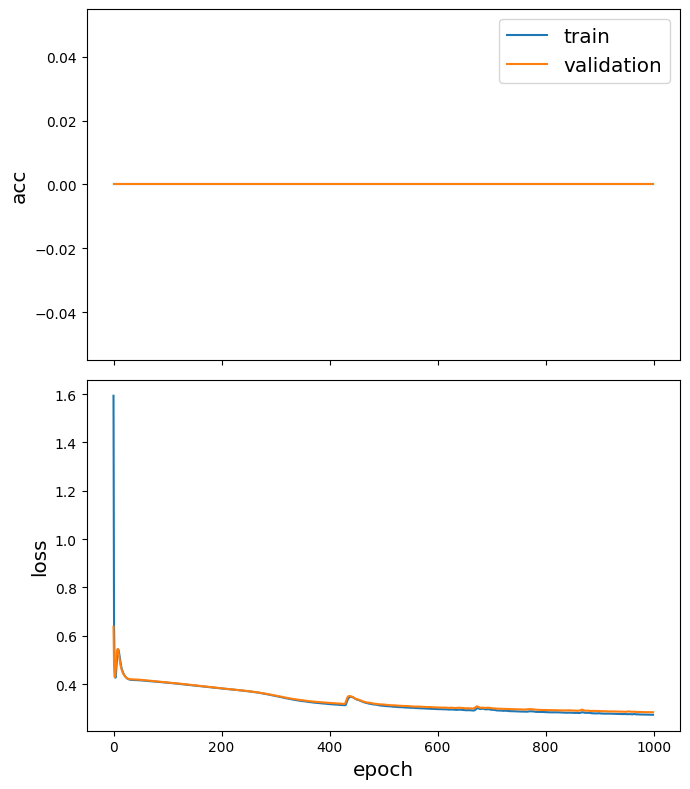

In [11]:
sg.utils.plot_history(history)
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

# Final Score

In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve

predict_y = model.predict(test_flow)

fpr, tpr, thresholds = metrics.roc_curve(labels_test, predict_y[0,:])
auc = metrics.auc(fpr, tpr)
print(auc)
# Average precision score
average_precision = average_precision_score(labels_test, predict_y[0,:])
print(average_precision)
# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(labels_test, predict_y[0,:])
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)
print(auc_precision_recall)

1/1 [==============================] - 0s 317ms/step
0.9055515602708024
0.6846978152462952
0.6846693898425318


# Save

In [13]:
df_pred = pd.DataFrame({"pred":predict_y[0,:]})
header = "./results/"
file_out = header + "GCN_pred.csv"
print(file_out)
df_pred.to_csv(file_out,index=False)
print(len(df_pred))
file_out_3 = header + "_df_node2cnt.csv"
df_node2cnt.to_csv(file_out_3,index=False)

./results/GCN_pred.csv
104268


# Get Embedding

In [14]:
embedding_model = keras.Model(inputs=x_inp, outputs=x_out)
generator = FullBatchNodeGenerator(graph_train, method="gcn")
all_nodes = list(df_node2cnt["node"])
all_gen = generator.flow(all_nodes)
emb = embedding_model.predict(all_gen)
X = emb.squeeze(0)
X.shape

file_out_2 = header +  "_GCN_node_emb.npz"
np.savez_compressed(file_out_2, X)

Using GCN (local pooling) filters...
1/1 [==============================] - 0s 256ms/step


# Load embedding

In [15]:
loaded = np.load(file_out_2)
X = loaded["arr_0"]

[None,
 Text(0.5, 0, '$X_1$'),
 Text(0, 0.5, '$X_2$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings')]

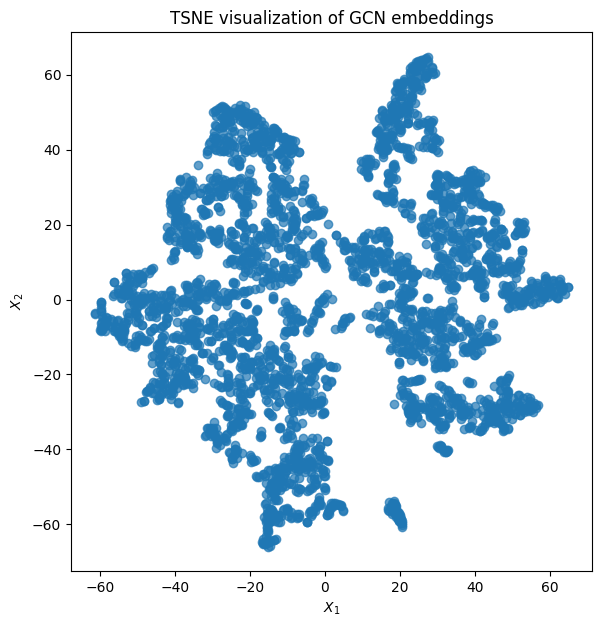

In [16]:

transform = TSNE  # or PCA
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    #c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings",
)